# OpenEO Connection to Google Earth Engine

In [1]:
import openeo
from openeo.internal.graph_building import PGNode
import json

In [2]:
# Define constants

# Connection
GEE_DRIVER_URL = "https://earthengine.openeo.org/v1.0"
OUTPUT_PATH = "/tmp/"
OUTFORMAT = "png"

# Auth
USER = "group15"
PASSWORD = "test123"

**First, we need to connect to the backend by logging in with our username and password. In this example we use the basic authentication, alternatively OIDC authentication can be used.**

In [3]:
# Connect with GEE backend and authenticate with basic authentication
con = openeo.connect(GEE_DRIVER_URL)
con.authenticate_basic(USER, PASSWORD)

<Connection to 'https://earthengine.openeo.org/v1.0' with BearerAuth>

**Load the Sentinel-1 data for one polarisation given a spatial and temporal boundary. The temporal extent includes all three time periods of interest, which are separated later on. It is the starting point of the process graph, by loading all input data needed for the workflow.**

In [4]:
# Select collection product to get a datacube object
datacube = con.load_collection("COPERNICUS/S1_GRD",
                               spatial_extent={"west": 16.06, "south": 48.1, "east": 16.65, "north": 48.31, "crs": "EPSG:4326"},
                               temporal_extent=["2017-03-01", "2017-06-01"],
                               bands=["VV"])

**In the next step we take the whole input data and separate it into three time periods. This is done by calling three filter_temporal functions, each one selecting the time range of one period of interest. Now we have three datacubes with the same spatial extent and polarisation, but three different temporal extents.**

In [5]:
# Filter the three time ranges of interest
march = datacube.filter_temporal("2017-03-01", "2017-04-01")
april = datacube.filter_temporal("2017-04-01", "2017-05-01")
may = datacube.filter_temporal("2017-05-01", "2017-06-01")

**Using the mean_time function, we can reduce the temporal dimension by calculating the statistics operation "mean". For each datacube it results in a single image of the calculation results (e.g. one image of the mean values from the stack of images in the selected time period).**

In [6]:
# Preparing the green color of the composite
mean_march = march.mean_time()
mean_april = april.mean_time()
mean_may = may.mean_time()

**After reducing the temporal dimension from the previous step, we have three separate images with each having the same polarisation band. We want to merge these images into one datacube to create the RGB composite, but since the bands have the same label, they would be merged into one image. We want to have three band labels for red, green and blue in our composite. Therefore, we rename each band label from our original polarisation to "R", "G" or "B" using "rename_labels".**

In [7]:
# Preparing the blue color of the composite
R_band = mean_march.rename_labels(dimension="bands", target=["R"])
G_band = mean_april.rename_labels(dimension="bands", target=["G"])
B_band = mean_may.rename_labels(dimension="bands", target=["B"])

**Now we merge all three images/datacubes into one datacube with the bands "R", "G" and "B" using two subsequent "merge" function calls.**

In [8]:
# Merging all color bands back into one datacube.
RG = R_band.merge(G_band)
RGB = RG.merge(B_band)

**Since we want to create a PNG image we need to bring the value range of the bands into the RGB value range of 0 to 255, therefore we change the range linearly in the next step**

In [9]:
# Linear scaling (just necessary because of png output format)
lin_scale = PGNode("linear_scale_range", arguments={"x": {"from_parameter": "x"},
                                                     "inputMin": -20, "inputMax": -5, "outputMin": 0, "outputMax": 255})
datacube = RGB.apply(lin_scale)

**In the last step we create the result image either by creating a GeoTiff or a PNG file. In the latter case, we need to define which band of the datacube should result in which RGB colour of the composite (using the "options" parameter).**

In [10]:
# Save resulting image as PNG, and also setting the connection to the PNG colors to the bands of the datacube.
datacube = datacube.save_result(format="PNG", options={"red": "R", "green": "G", "blue": "B"})

In [11]:
# Sending the job to the backend
job = datacube.send_job()
results = job.start_and_wait().download_results()
results

0:00:00.000001 Job 'owUYSiEViyKhX7Yf': running (progress N/A)
0:00:05.082374 Job 'owUYSiEViyKhX7Yf': finished (progress N/A)


{PosixPath('/data/REPO/openeo-python-client/examples/notebooks/3241906d6eb92e41.png'): {'href': 'https://earthengine.openeo.org/v1.0/storage/owUYSiEViyKhX7Yf/3241906d6eb92e41.png',
  'rel': 'data',
  'type': 'image/png'},
 PosixPath('/data/REPO/openeo-python-client/examples/notebooks/logs.db'): {'href': 'https://earthengine.openeo.org/v1.0/storage/owUYSiEViyKhX7Yf/logs.db',
  'rel': 'data',
  'type': 'application/octet-stream'}}

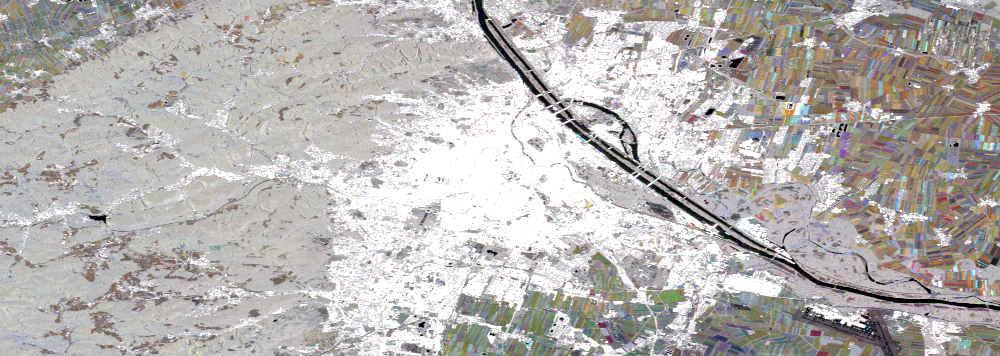

In [12]:
# Showing the result
from IPython.display import Image
for key, val in results.items():
    if ".png" in key.name:
        result = Image(filename=str(key))

result